# Importing libraries

In [ ]:
# !pip install imutils

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import h5py
from tensorflow.keras.models import load_model
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

#################### Importing wheigts #####################################
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.applications import mobilenet_v3
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.applications import NASNetLarge, Xception
#########################################################

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint, CSVLogger
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
import pandas as pd

In [2]:
# Defining Global Variables
labels = ['glioma_tumor','meningioma_tumor','pituitary_tumor']
image_size = 224
# 'C:\\Users\\98939\\Desktop\\BC_Project\\Data'
# 'Training'

In [3]:
def image_resizer(initialPath, TrainPath, TestPath):
    X_train = []
    y_train = []
    for i in labels:
        folderPath = os.path.join(initialPath,TrainPath,i)
        for j in tqdm(os.listdir(folderPath)):
            img = cv2.imread(os.path.join(folderPath,j))
            img = cv2.resize(img,(image_size, image_size))
            X_train.append(img)
            y_train.append(i)

    for i in labels:
        folderPath = os.path.join(initialPath,TestPath,i)
        for j in tqdm(os.listdir(folderPath)):
            img = cv2.imread(os.path.join(folderPath,j))
            img = cv2.resize(img,(image_size,image_size))
            X_train.append(img)
            y_train.append(i)

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    return X_train, y_train

In [4]:
X_train, y_train = image_resizer('C:\\Users\\Eurus\\Desktop\\B.Sc_Project\\Data','Training','Testing')

100%|█████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 186.12it/s]


# ! Under Construction !

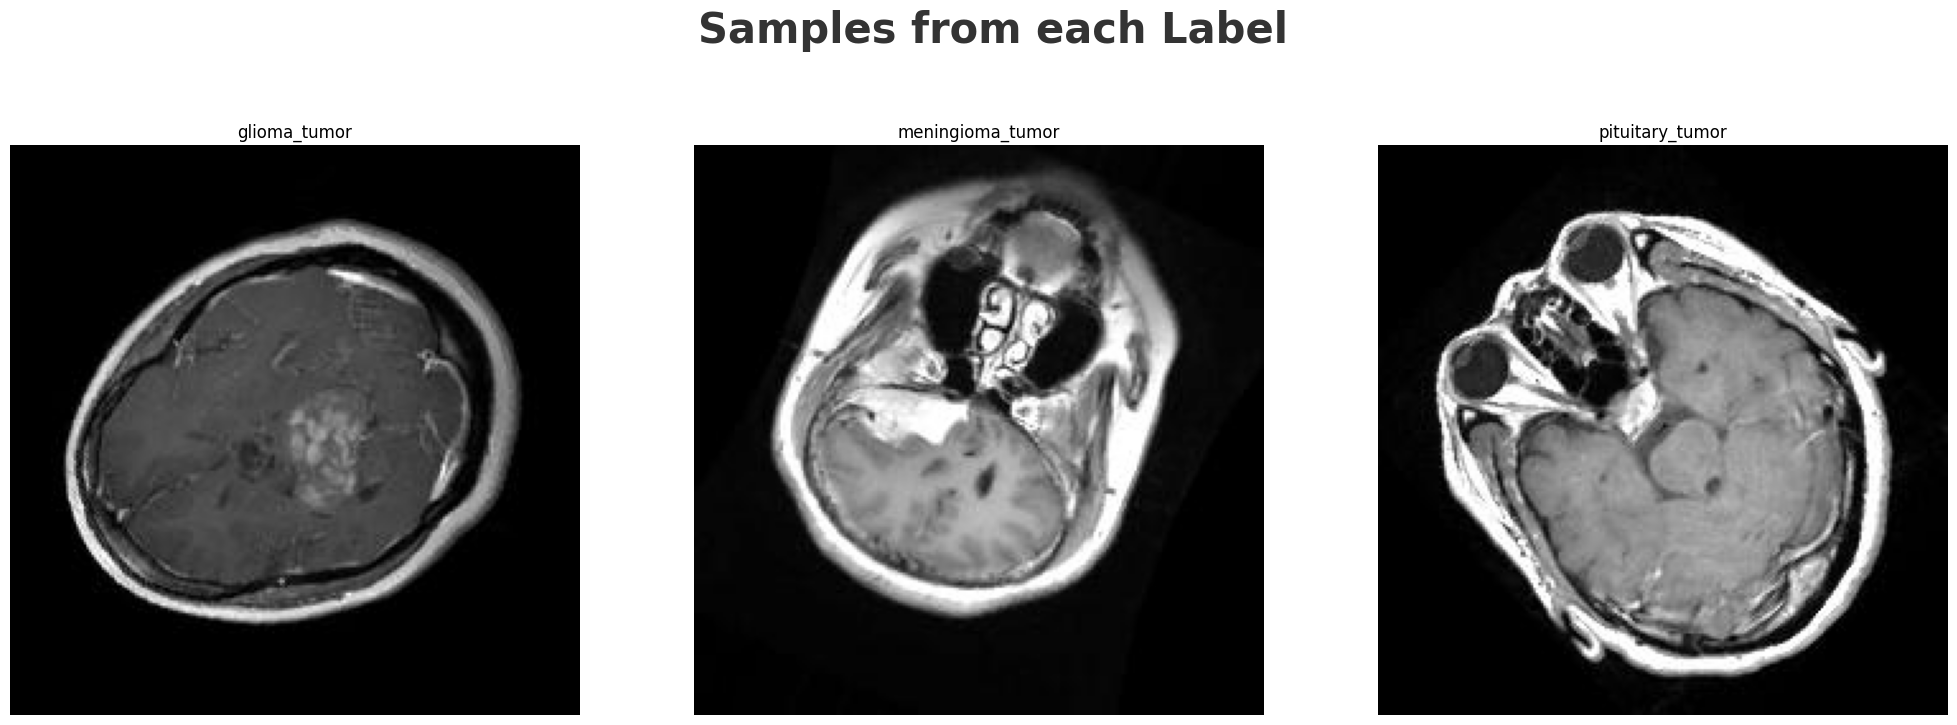

In [12]:
k = 0
fig, ax = plt.subplots(1,3,figsize=(25,25))
fig.text(s='Samples from each Label', size = '30',fontweight='bold',y=0.65,x=0.4,alpha=0.8)

for i in labels:
    j=0 
    while True:
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [13]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state = 1)

In [14]:
X_train.shape

(14850, 224, 224, 3)

In [15]:
# Splitting the data to train and test
X_train, X_test, y_train, y_test = train_test_split(X_train,y_train, test_size=0.2, random_state=110)

In [16]:
def label_categorizer(init_list):
    temp_list = []
    for i in init_list:
        temp_list.append(labels.index(i))
    final_list = temp_list
    final_list = tf.keras.utils.to_categorical(final_list)
    
    return final_list 


In [17]:
y_train = label_categorizer(y_train)

In [18]:
y_test = label_categorizer(y_test)

In [19]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [20]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(3,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [ ]:
# model.summary()

In [21]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [22]:
tensorboard = TensorBoard(log_dir = 'C:\\Users\\Eurus\\Desktop\\B.Sc_Project\\Visulizations\\TrainingLogs\\Augmentation_V2\\EfficientNetB0.csv')
checkpoint = ModelCheckpoint("EfficientNetB0.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [25]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =15, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr], steps_per_epoch=150)

Epoch 1/15


ResourceExhaustedError:  OOM when allocating tensor with shape[7680,29,29] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/block4a_dwconv_pad/Pad (defined at \AppData\Local\Temp\ipykernel_10336\2316022416.py:1) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_16054]

Function call stack:
train_function


In [ ]:
epochs = [i for i in range(15)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()